In [169]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from IPython.display import Image
import time
import warnings
warnings.filterwarnings("error")

I ran Jon's `planck_likelihood.py` script with the two sets of initial guesses and plot the results and the $\chi^2$ values. First, I use: `[60,0.02,0.1,0.05,2.00e-9,1.0]` for the parameters.

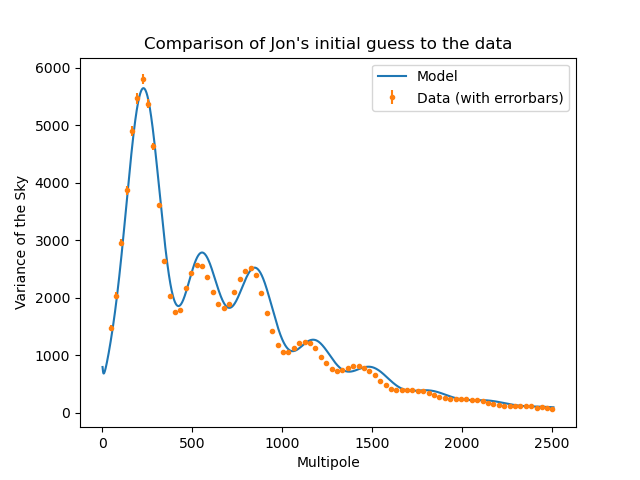

In [170]:
Image(filename="./planck_likelihood_plots.png", width=800, height=800)

The output on my terminal when I ran `planck_likelihood.py` was:

`(base) PS C:\Users\snitt\Downloads\mcmc> python .\planck_likelihood.py
chisq is  15267.937150261654  for  2501  degrees of freedom.`

Just based on the $\chi^2$ value, I would think this is a rather poor fit. I would expect that $\chi^2 \approx n = 2501 \pm 71 (\sqrt{2n})$ for a good fit. We are about 200 sigma's away from what can be considered to be a good fit.

I change the guess parameters to `[69. 0.022, 0.12, 0.06, 2.1e-9, 0.95]`. I get the following results.

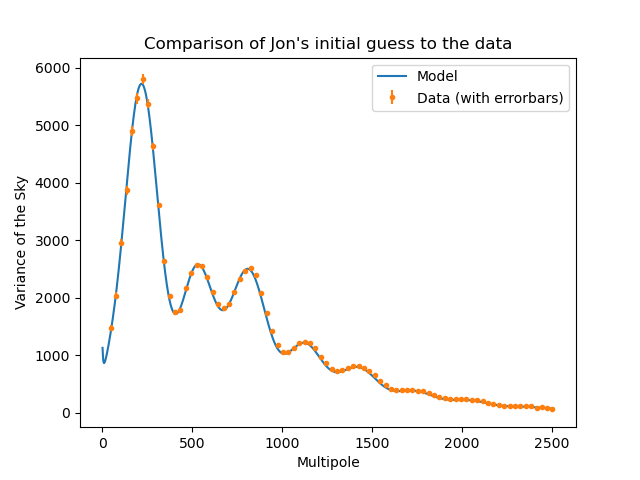

In [171]:
Image(filename="./planck_likelihood_plots_newpars.png", width=800, height=800)

`(base) PS C:\Users\snitt\Downloads\mcmc> python .\planck_likelihood.py
chisq is  3272.2053559202204  for  2501  degrees of freedom.`

This $\chi^2$ value is a lot better than earlier. However, it is still NOT an acceptable fit, since the uncertainty in $\chi^2$ about its average value $n$ is $\sigma = \sqrt{2n} = \sqrt{5002} \approx 71 $. Our $\chi^2$ value is still about 10 $\sigma$'s away from the average $\chi^2$ value. 

Next, I read in the CMB data to do my own fits.

In [172]:
data_full = np.loadtxt("./COM_PowerSpect_CMB-TT-full_R3.01.txt", skiprows=1)
data_binned = np.loadtxt("./COM_PowerSpect_CMB-TT-binned_R3.01.txt")  # for plotting

multipole = data_full[:,0]  # x data
variance = data_full[:,1]  # y data
onesigma = 0.5*(data_full[:,2] + data_full[:,3])  # assumed gaussian errors
nparams = 6  # number of parameters
dof = len(multipole) - nparams  # degrees of freedom in the data

paramlist = np.asarray(['H0', 'ombh2', 'omch2', 'tau', 'As', 'ns'])

Below I define some helper functions that I directly copied from my previous assignment. `num_der()` is a function that returns the numerical gradient with respect to the parameters of my model. I use central differences with a step $dp = p * (10^{-16})^{1/3}$, which is the usual rule of thumb estimate for this scheme. 
`get_spectrum()` is copied as is from `planck_likelihood.py` and it makes the CAMB function calls to get the model evaluations for the input parameters.
`get_chisq()` returns the $\chi^2$ values, given the model, data, parameters and noise.
`Newton()` minimizes $\chi^2$ using gradient descent. I described this already in a previous homework so I will not re-type the whole explanation. The basic equation that one arrives at for a step in parameter space $\delta m$ is:

$ (A^T N^{-1} A )(\delta m) = (A^T N^{-1})(d-A(m))$

Where $A$ is the gradient matrix that is returned by `num_der`, $N^{-1}$ is the data covariance matrix. It is a diagonal matrix with non-zero elements $1/\sigma_i^2$ where $\sigma_i$ is the noise in the i-th data entry. To solve this equation, I use SVD. First, I use a Cholesky decomposition to get rid of the $N^{-1} = L L^T$. Then I rotate my data and model: $\overline{A} = L^{-1} A, \overline{r} = L^{-1} (d-A(m))$, which makes the above equation:

$ \overline{A}^T \overline{A} \delta m = \overline{A} \overline{r} $ 

which can then be solved via SVD by putting $\overline{A} = USV^T$ as we did in class, which ultimately gives:

$ \delta m = V^T S^{-1} U^T \overline{r} $.

The way my algorithm works is, I take a trial step using the above process, if it decreases $\chi^2$ then I accept this step and update my parameters. If the $\chi^2$ increases, I exit the while loop without updating the parameters. The function then returns the best fit parameters.

Then, I call `Newton()` with my guess parameters from before and get the best fit parameters.

In [173]:
def num_der(model, p):
    grad = np.zeros((len(model(p)), len(p)))
    dp = (1E-16)**(1/3) * p
    for i in range(len(p)):
        try:
            p_left = p.copy()
            p_left[i] = p[i]-dp[i]
            p_right = p.copy()
            p_right[i] = p[i] + dp[i]
            grad[:,i] = (model(p_right) - model(p_left))/2/dp[i]
    
        except:
            print(i, p[i], dp[i])
            break
            
    return grad

def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    model = tt[2:]
    return model[:len(variance)]

def get_chisq(p, model = get_spectrum, noise = onesigma, data=variance):
    return np.sum((model(p)-data)**2/noise**2)

def Newton(p0, model = get_spectrum, d = variance, derivative = num_der, noise = onesigma, tol=1E-1):
    dp = 1*np.ones(len(p0))
    p = p0.copy()
    p_t = np.zeros(len(p))
    chisq_old = get_chisq(p)
    chisq_new = 1
    Ninv = np.diag(1/noise**2)
    L = np.linalg.cholesky(Ninv)
    Linv = np.linalg.inv(L)
    print("Trial Chi-squared: ", chisq_old)
    print("Entered Newton loop")
    
    
    while chisq_old-chisq_new > 0:
        
        chisq_old = get_chisq(p)
        pred = model(p)
        grad = derivative(model,p)
        r = d - pred
        #err=(r**2).sum()
        r=r.transpose()
        #grad=np.matrix(grad)
        A_bar = Linv@grad
        r_bar = Linv@r
        
        u,s,v=np.linalg.svd(A_bar,0)
        dp=v.T@np.diag(1/s)@u.T@r_bar
        
        
        for jj in range(p_t.size):
            p_t[jj]=p[jj]+dp[jj]
            
        chisq_new = get_chisq(p_t)
        
        
        if chisq_new < chisq_old:
            p = p_t.copy()
            print("Updated Chi-squared: ", chisq_new)
        else:
            print("Trial Update Chi-Squared: ", chisq_new)
            print("Chi-squared went up! Rejecting this value and returning previous run's values.")
            break  
        
    print("Exiting Newton Loop")
        
    return p

p0 = np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])

pars = Newton(p0)
chisq_old = get_chisq(p0)
chisq_new = get_chisq(pars)

print("Parameters are: ", pars)
print("Original Chi-squared was ", chisq_old, " with ", dof, " degrees of freedom.")
print("Chi-squared for fit is ", chisq_new, " with ", dof, " degrees of freedom.")

Trial Chi-squared:  3272.2053559202204
Entered Newton loop
Updated Chi-squared:  2606.387388988674
Trial Update Chi-Squared:  2607.1724688365703
Chi-squared went up! Rejecting this value and returning previous run's values.
Exiting Newton Loop
Parameters are:  [6.51780761e+01 2.21061545e-02 1.23213494e-01 9.15951262e-02
 2.27314190e-09 9.55497712e-01]
Original Chi-squared was  3272.2053559202204  with  2501  degrees of freedom.
Chi-squared for fit is  2606.387388988674  with  2501  degrees of freedom.


The new $\chi^2$ value is within $1.5 \sigma$ of the expected value. Which is significantly better than what we had before!

Below, I compute the curvature matrix $A^T N^{-1} A $ at the bestfit parameter values. This will be my estimate for the errors in my fit parameters. I then save the parameters, errors in a file called `planck_fit_params.txt` and I also save the curvature matrix in `newton_covariance_matrix.txt`.

In [174]:
def get_pcov(p_bestfit, model = get_spectrum, derivative = num_der, noise = onesigma, data=variance):
    A = derivative(model, p_bestfit)
    Ninv = np.diag(1/noise**2)
    pcov = np.linalg.inv(A.T @ Ninv @ A)
    return pcov

pcov = get_pcov(pars)
errs = np.sqrt(np.diag(pcov))

newton_params = np.c_[pars, errs]
print_params = np.c_[paramlist, pars, errs]
print("Newton fit paramters (col 1), values (col 2) and errors (col 3): \n", print_params)
np.savetxt('./planck_fit_params.txt', newton_params)
np.savetxt('./newton_covariance_matrix.txt', pcov)

Newton fit paramters (col 1), values (col 2) and errors (col 3): 
 [['H0' '65.17807612170049' '1.1648762431100388']
 ['ombh2' '0.02210615450101605' '0.00022498748300116603']
 ['omch2' '0.12321349383032754' '0.0027730929995777257']
 ['tau' '0.09159512618683147' '0.03205979925001507']
 ['As' '2.273141898108182e-09' '1.3662789136481475e-10']
 ['ns' '0.9554977116627704' '0.006556627767531695']]


I then read in the paramters from the file I made and plot the new model on top of the original model and the data to see how the fit looks.

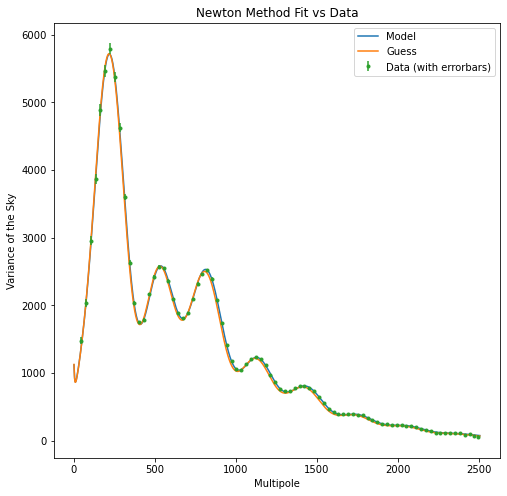

In [175]:
newton_data = np.loadtxt('./planck_fit_params.txt')
pars = newton_data[:,0]
errs = newton_data[:,1]
pcov = np.loadtxt('./newton_covariance_matrix.txt')
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
model = get_spectrum(pars)
trial = get_spectrum(p0)
plt.rcParams['figure.figsize'] = (8,8)
plt.clf()
plt.plot(multipole,model, label="Model")
plt.plot(multipole,trial, label="Guess")
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.', label = 'Data (with errorbars)')
plt.xlabel("Multipole")
plt.ylabel("Variance of the Sky")
plt.title("Newton Method Fit vs Data")
plt.legend()
plt.show()

The fit is much better for large multipoles, but does not seem to be appreciably better than the guess values near the first (largest) peak.

(c) Next I run an MCMC chain with trial steps sampled from the covariance matrix generated earlier. This part is also copied directly from my previous assignment so I won't reexplain it all. I did not need to put in any overall scaling in order for my chain to converge in 10000 steps. At the end of the chain, I write the $\chi^2$ values and the parameter values in a file called `planck_chain.txt`.

In [176]:
def get_step(pcov):
    L = np.linalg.cholesky(pcov)
    dm = L @ (np.random.randn(np.shape(pcov)[0]))
    return dm

def mcmc(p0 , pcov, filepath, scale = 1.0, T = 1.0, nstep=10000):

    start = time.time()
    chain = np.zeros([nstep, len(p0)])
    chain[0,:] = p0
    chisq_list = np.zeros(nstep)
    chisq_old = get_chisq(p0)
    chisq_list[0] = chisq_old

    for i in range(1,nstep):

        pp = chain[i-1,:] + scale*get_step(pcov)
        
        if np.min(pp)>=0:  # reject steps if any parameters are negative
            chisq_new = get_chisq(pp)
            chisq_diff = chisq_new - chisq_old

            try:
                accept = np.exp(-0.5*(chisq_diff)/T)

                if accept>np.random.rand(1):
                    chain[i,:] = pp
                    chisq_old = chisq_new
                    chisq_list[i] = chisq_old

                else:
                    chain[i,:] = chain[i-1,:]
                    chisq_list[i] = chisq_old
            except:
                chain[i,:] = chain[i-1,:]
                chisq_list[i] = chisq_old
                
        else:
            chain[i,:] = chain[i-1,:]
            chisq_list[i] = chisq_old

    end = time.time()

    print("Time for {} iterations: ".format(nstep), end-start)

    savedata = np.c_[chisq_list, chain]

    np.savetxt(filepath, savedata)

    print("Saved to file at '{}' successfully!".format(filepath))
    
    return chisq_list, chain

chisq_list, chain = mcmc(p0, pcov, './planck_chain.txt')

Time for 10000 iterations:  15481.54323220253
Saved to file at './planck_chain.txt' successfully!


I already have the chain and the list of $\chi^2$, but if I didn't I could use the lines that have been commented out to read in these values from the file, and make some plots to see if my chain converged.

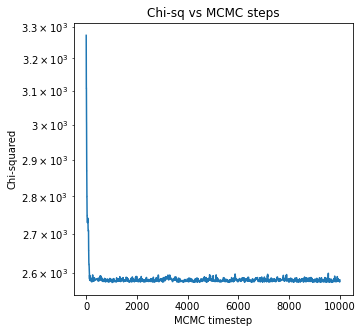

In [177]:
# read in data and plot, so don't have to run the chain over and over again

#mcmc_data = np.loadtxt('./planck_chain.txt')
#chisq_list = mcmc_data[:,0]
#chain = mcmc_data[:,1:]

def plot_chisq_chain(chisq_list):
    plt.rcParams['figure.figsize'] = (5,5)
    plt.clf()
    plt.semilogy(range(len(chisq_list)), chisq_list)
    plt.ylabel("Chi-squared")
    plt.xlabel("MCMC timestep")
    plt.title("Chi-sq vs MCMC steps")
    plt.show()

plot_chisq_chain(chisq_list)

<Figure size 360x360 with 0 Axes>

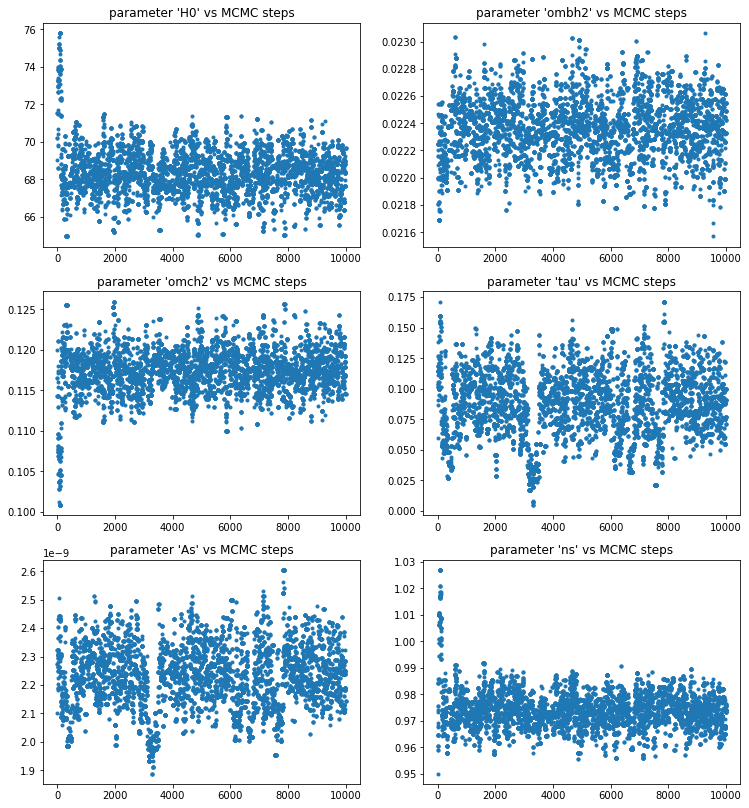

In [178]:
def plot_parameter_chain(chain):
    plt.clf()

    plt.rcParams['figure.figsize'] = (12.5,14)
    fig, axes = plt.subplots(3,2)
    ax1 = axes[0,0]
    ax2 = axes[0,1]
    ax3 = axes[1,0]
    ax4 = axes[1,1]
    ax5 = axes[2,0]
    ax6 = axes[2,1]
    N = np.shape(chain)[0]
    
    ax1.plot(range(N), chain[:,0], '.')
    ax1.set_title("parameter 'H0' vs MCMC steps")

    ax2.plot(range(N), chain[:,1], '.')
    ax2.set_title("parameter 'ombh2' vs MCMC steps")

    ax3.plot(range(N), chain[:,2], '.')
    ax3.set_title("parameter 'omch2' vs MCMC steps")

    ax4.plot(range(N), chain[:,3], '.')
    ax4.set_title("parameter 'tau' vs MCMC steps")

    ax5.plot(range(N), chain[:,4], '.')
    ax5.set_title("parameter 'As' vs MCMC steps")

    ax6.plot(range(N), chain[:,5], '.')
    ax6.set_title("parameter 'ns' vs MCMC steps")

    plt.show()
    
plot_parameter_chain(chain)

I feel fairly confident that my random walker is properly sampling the parameter space and that the time spent in the vicinity of any point is representative of the probability density at that point for steps>3000 in the above plots. Based on this, I think my chain has converged!

<Figure size 864x864 with 0 Axes>

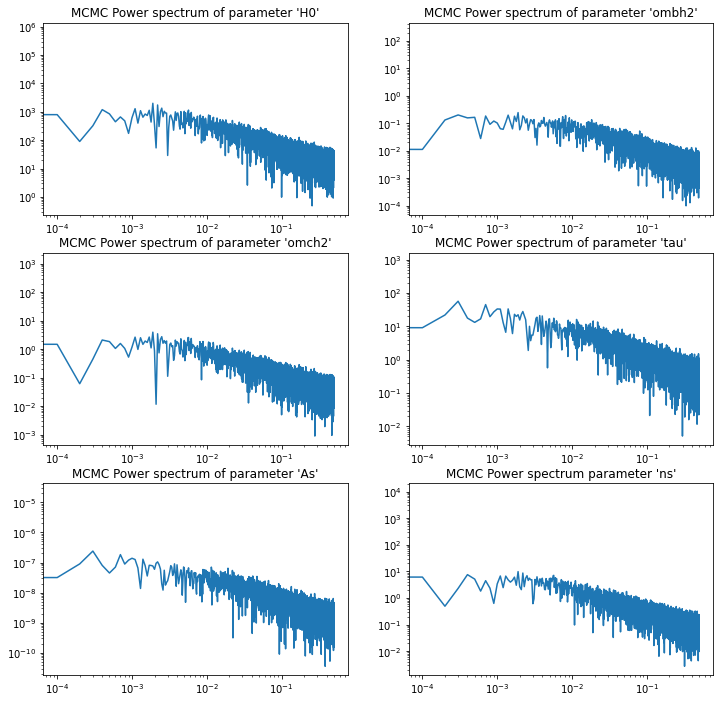

In [253]:
def plot_power_spectrum(chain):
    nstep = np.shape(chain)[0]
    freq = np.fft.rfftfreq(nstep)
    fft0 = np.abs(np.fft.rfft(chain[:,0]))
    fft1 = np.abs(np.fft.rfft(chain[:,1]))
    fft2 = np.abs(np.fft.rfft(chain[:,2]))
    fft3 = np.abs(np.fft.rfft(chain[:,3]))
    fft4 = np.abs(np.fft.rfft(chain[:,4]))
    fft5 = np.abs(np.fft.rfft(chain[:,5]))

    plt.clf()
    plt.rcParams['figure.figsize'] = (12,12)
    fig, axes = plt.subplots(3,2)
    ax1 = axes[0,0]
    ax2 = axes[0,1]
    ax3 = axes[1,0]
    ax4 = axes[1,1]
    ax5 = axes[2,0]
    ax6 = axes[2,1]

    ax1.loglog(freq, fft0)
    ax1.set_title("MCMC Power spectrum of parameter 'H0'")

    ax2.loglog(freq, fft1)
    ax2.set_title("MCMC Power spectrum of parameter 'ombh2'")

    ax3.loglog(freq, fft2)
    ax3.set_title("MCMC Power spectrum of parameter 'omch2'")

    ax4.loglog(freq, fft3)
    ax4.set_title("MCMC Power spectrum of parameter 'tau'")

    ax5.loglog(freq, fft4)
    ax5.set_title("MCMC Power spectrum of parameter 'As'")

    ax6.loglog(freq, fft5)
    ax6.set_title("MCMC Power spectrum parameter 'ns'")

    plt.show()

plot_power_spectrum(chain)

Curves are flat in the vicinity of $k=0$ and it appears to be levelling off in the left half of the plot. This is further evidence that my chain has converged.

I think 3000 steps onwards is a good place to start for computing averages.

In [318]:
start = 3000
fitp_mcmc = np.mean(chain[start:,:], axis=0)
fitp_mcmc_errs = np.std(chain[start:,:], axis=0)

np.savetxt('./planck_')
mcmc_params = np.c_[paramlist, fitp_mcmc, fitp_mcmc_errs]
print("MCMC Fit paramters (col 1), means (col 2) and errors (col 3): \n", mcmc_params)

MCMC Fit paramters (col 1), means (col 2) and errors (col 3): 
 [['H0' '68.24747246659412' '1.0798841715446263']
 ['ombh2' '0.02236029380624619' '0.00022100570658577503']
 ['omch2' '0.11766589089687068' '0.0023961939928962128']
 ['tau' '0.08542698409508369' '0.027582012785432']
 ['As' '2.2217620649564845e-09' '1.1645042896897375e-10']
 ['ns' '0.9733311408234172' '0.005963986856618389']]


2576.9636950727527


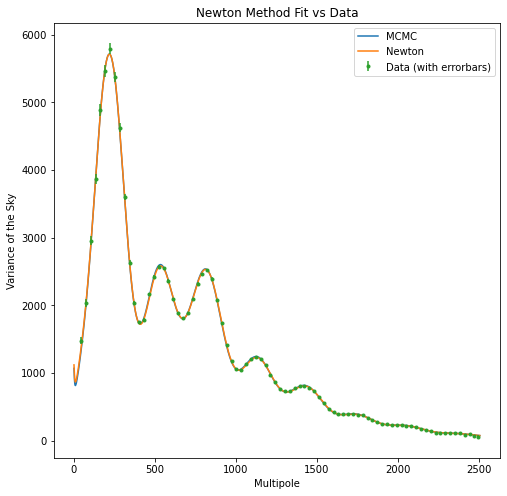

In [319]:
mcmcchisq = get_chisq(fitp_mcmc)
print(mcmcchisq)
mcmcmodel = get_spectrum(fitp_mcmc)
newtonmodel = get_spectrum(pars)
trial = get_spectrum(p0)
plt.rcParams['figure.figsize'] = (8,8)
plt.clf()
plt.plot(multipole, mcmcmodel, label="MCMC")
plt.plot(multipole,newtonmodel, label="Newton")
#plt.plot(multipole,trial, label="Guess")
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.', label = 'Data (with errorbars)')
plt.xlabel("Multipole")
plt.ylabel("Variance of the Sky")
plt.title("Newton Method Fit vs Data")
plt.legend()
plt.show()

Dark Energy estimation:

Let $\omega_b = \Omega_b h_0^2 = \frac{\Omega_b H_0^2}{10^4}, \omega_c =\Omega_c h_0^2 = \frac{\Omega_c H_0^2}{10^4}$ ($\omega_b, \omega_c, H_0$ are parameters we get from the fit), then:

$\Omega_{\Lambda} = 1 - (\Omega_b + \Omega_c) = 1 - 10^4 \bigg( \frac{\omega_b + \omega_c}{H_0^2} \bigg)$

$ \delta \Omega_{\Lambda} = \bigg| 2*10^4 \bigg( \frac{\omega_b + \omega_c}{H_0^3} \bigg) [\delta H_0] \bigg| + \bigg| \bigg( \frac{10^4}{H_0^2} \bigg) \bigg[ \delta \omega_b + \delta \omega_c \bigg] \bigg| $

In [204]:
omlambda = 1 - 1E4 * (fitp_mcmc[1] + fitp_mcmc[2])/(fitp_mcmc[0]**2)
err_omlambda = np.abs((2E4/fitp_mcmc[0]**3) * (fitp_mcmc[1] + fitp_mcmc[1]) * fitp_mcmc_errs[0] + (1E4/fitp_mcmc[0]**2)*(fitp_mcmc_errs[1] + fitp_mcmc_errs[2]))
    
print("The Dark Energy is: ", omlambda, " +/- ", err_omlambda)

The Dark Energy is:  0.6993673730515371  +/-  0.008657530651842767


(4) 

Importance Sampling:

Upon discussing this with Marcus and another classmate (Leo), I understood that the simplest way to properly weight the individual MCMC steps from earlier was to use a penalty function which increased $\chi^2$ as we move further away from the prior. Provided the old and new $\tau$ values are not too far off (otherwise we really should not be relying on importance sampling), we get $\chi^2_{\text{new}} \approx \chi^2_{\text{old}} + \frac{(\tau - \tau_{prior})^2}{\sigma_{\tau}^2} + \text{[maybe a linear term that averages to zero and isn't too important]}$ which would make the likelihood ratio $ e^{- \frac{\chi^2_{\text{new}}-\chi^2_{\text{old}}}{2}} \approx e^{- \frac{(\tau - \tau_{prior})^2}{2 \sigma_{\tau}^2}}$. Here the products are taken at each timestep and the averaging is over the mcmc timesteps.

I multiply each of the parameters in the converged part (~ 3000 timesteps onwards) of my previous MCMC chain by these weights to take the weighted average. I also take the weigthed average of products of parameters $\langle p_i p_j \rangle_{\text{weighted}} - \langle p_i \rangle \langle p_j \rangle_{\text{weighted}}$ to get the covariance matrix.

The goal is to then update my initial guess with the known average value, and to compute a new covariance matrix from the chain generated by importance sampling and to use this new covariance matrix to run a new MCMC chain. For this new chain, I use a modified $\chi^2$ that takes on larger values as $\tau$ moves further away from the prior value by basically defining: $\chi^2_{\text{new}} \approx \chi^2_{\text{old}} + \frac{(\tau - \tau_{prior})^2}{\sigma_{\tau}^2}$ as before.

Finally, I check if this chain has converged and print the parameters and errors and compare them to the importance sampling case.

In [399]:
warnings.simplefilter("error")
from IPython.display import clear_output

tauprior = 0.0540
tauprior_std = 0.0074

nstep = len(chisq_list)
start = 3000

old_pars = chain[start:,:].copy()

In [409]:
penalty = (old_pars[:,3] - tauprior)**2/tauprior_std**2
weights = np.exp(-0.5*penalty)
sumweights = np.sum(weights)
new_fitp = np.zeros(len(p0))
pcov_new = np.zeros((len(p0), len(p0)))
prob = weights/sumweights

for j in range(len(p0)):
    new_fitp[j] = np.sum(old_pars[:,j]*prob)

for i in range(len(p0)):
    for j in range(len(p0)):
        pcov_new[i,j] = np.sum((old_pars[:,i]) * (old_pars[:,j]) * prob ) - new_fitp[i]*new_fitp[j]

new_errs = np.sqrt(np.diag(pcov_new))
new_mcmc_params = np.c_[paramlist, new_fitp, new_errs]

np.savetxt('./planck_tauprior_impsamp_pars.txt', np.c_[new_fitp, new_errs])
print("Importance Sampling MCMC Fit paramters (col 1), means (col 2) and errors (col 3): \n", new_mcmc_params)

Importance Sampling MCMC Fit paramters (col 1), means (col 2) and errors (col 3): 
 [['H0' '67.72238696791487' '1.1046298503815124']
 ['ombh2' '0.02228459139448169' '0.00021624942591550898']
 ['omch2' '0.11880775618478037' '0.002393858587491717']
 ['tau' '0.05554550275934359' '0.007337179611323888']
 ['As' '2.096853374989576e-09' '3.1702735869668887e-11']
 ['ns' '0.9706896804145031' '0.006352045427367535']]


In [401]:
def get_newchisq(p, tauprior, tauprior_error, model = get_spectrum, noise = onesigma, data=variance):
    return np.sum((model(p)-data)**2/noise**2) + (p[3] - tauprior)**2/tauprior_error**2

def mcmc_constraint(p0 , pcov, filepath, tauprior, tauprior_error, scale = 1.0, T = 1.0, nstep=10000):

    start = time.time()
    chain = np.zeros([nstep, len(p0)])
    chain[0,:] = p0
    chisq_list = np.zeros(nstep)
    chisq_old = get_newchisq(p0, tauprior, tauprior_error)
    chisq_list[0] = chisq_old

    for i in range(1,nstep):
        
        print("iter = {}/{}".format(i,nstep))
        clear_output(wait=True)
        pp = chain[i-1,:] + scale*get_step(pcov)
        
        
        
        if np.min(pp)>=0:  # reject steps if any parameters are negative
            chisq_new = get_newchisq(pp, tauprior, tauprior_error)
            chisq_diff = chisq_new - chisq_old

            try:
                accept = np.exp(-0.5*(chisq_diff)/T)

                if accept>np.random.rand(1):
                    chain[i,:] = pp
                    chisq_old = chisq_new
                    chisq_list[i] = chisq_old

                else:
                    chain[i,:] = chain[i-1,:]
                    chisq_list[i] = chisq_old
                    
            except:
                chain[i,:] = chain[i-1,:]
                chisq_list[i] = chisq_old
                
        else:
            chain[i,:] = chain[i-1,:]
            chisq_list[i] = chisq_old

    end = time.time()

    print("Time for {} iterations: ".format(nstep), end-start)

    savedata = np.c_[chisq_list, chain]

    np.savetxt(filepath, savedata)

    print("Saved to file at '{}' successfully!".format(filepath))
    
    return chisq_list, chain

In [403]:
p0_new = p0.copy()
p0_new[3] = tauprior
new_chisq_list, new_chain = mcmc_constraint(p0_new, pcov_new, './planck_chain_tauprior.txt', tauprior, tauprior_std, scale = 1.0)

Time for 10000 iterations:  16447.079762220383
Saved to file at './planck_chain_tauprior.txt' successfully!


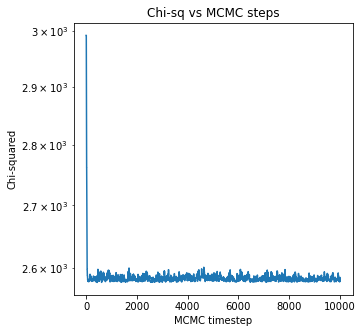

In [404]:
plot_chisq_chain(new_chisq_list)

<Figure size 360x360 with 0 Axes>

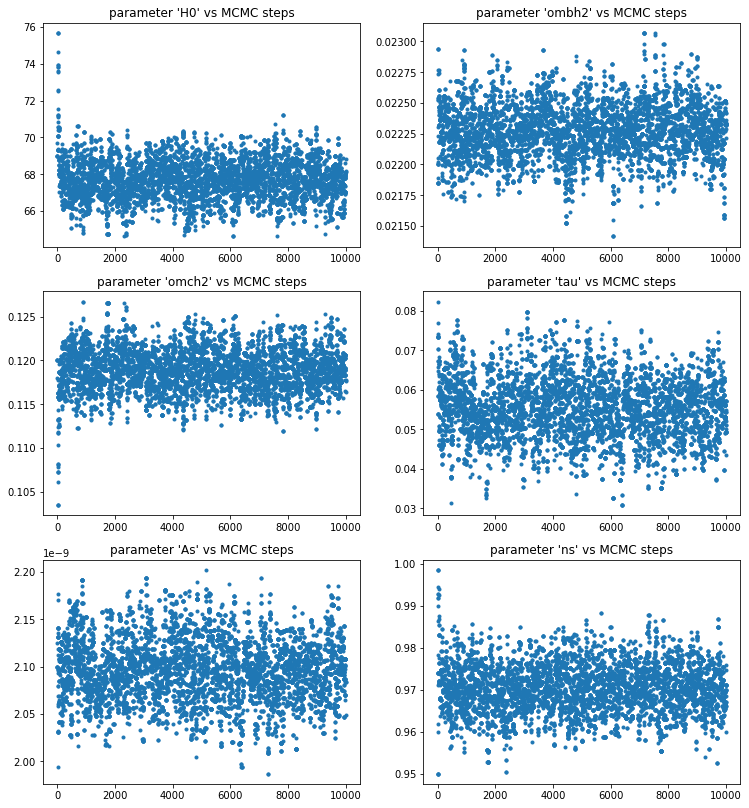

In [405]:
plot_parameter_chain(new_chain)

<Figure size 900x1008 with 0 Axes>

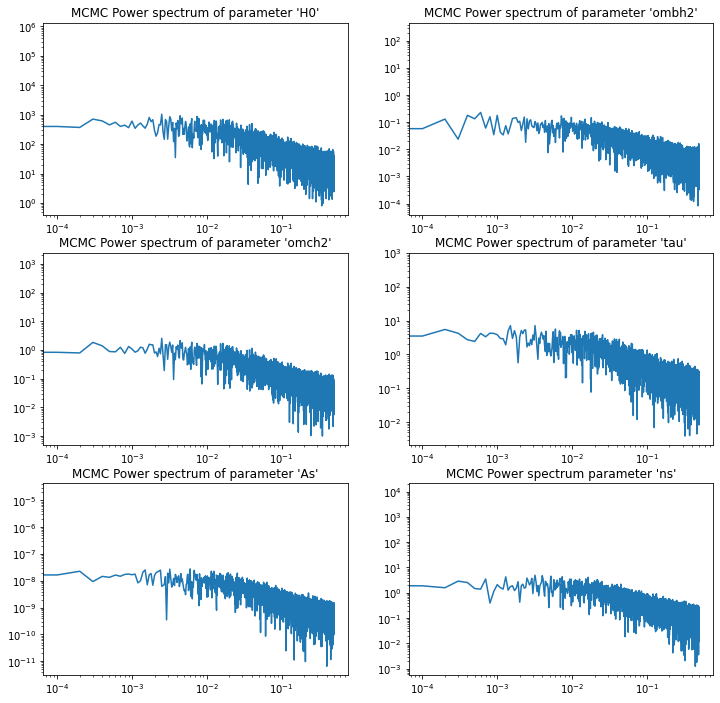

In [406]:
plot_power_spectrum(new_chain)

Okay the power spectra have flattened in the large k region and the MCMC chain looks like it has reliably converged to some average values for the parameters and is fairly accurately sampling the neighborhoods of these values, i.e. the density in parameter space seems to be random and reflective of the underlying covariances. I will now print these values and compare them to the importance sampling.

In [410]:
final_mcmc_pars = np.mean(new_chain[3000:,:], axis=0)
final_mcmc_errs = np.std(new_chain[3000:,:], axis = 0)

print_final_mcmc = np.c_[paramlist, final_mcmc_pars, final_mcmc_errs]
np.savetxt('./planck_tauprior_mcmc_pars.txt', np.c_[final_mcmc_pars, final_mcmc_errs] )
print("Constrained MCMC Fit paramters (col 1), means (col 2) and errors (col 3): \n", print_final_mcmc)

Constrained MCMC Fit paramters (col 1), means (col 2) and errors (col 3): 
 [['H0' '67.71257444966926' '1.0133296488666075']
 ['ombh2' '0.022283319088171348' '0.0002118670625904462']
 ['omch2' '0.11887670063387767' '0.0023097836037986835']
 ['tau' '0.05549465191313149' '0.007482944427481495']
 ['As' '2.097001235496996e-09' '3.227171062886683e-11']
 ['ns' '0.9706256572509714' '0.005466871822691887']]


In [411]:
print("Importance Sampling MCMC Fit paramters (col 1), means (col 2) and errors (col 3): \n", new_mcmc_params)

Importance Sampling MCMC Fit paramters (col 1), means (col 2) and errors (col 3): 
 [['H0' '67.72238696791487' '1.1046298503815124']
 ['ombh2' '0.02228459139448169' '0.00021624942591550898']
 ['omch2' '0.11880775618478037' '0.002393858587491717']
 ['tau' '0.05554550275934359' '0.007337179611323888']
 ['As' '2.096853374989576e-09' '3.1702735869668887e-11']
 ['ns' '0.9706896804145031' '0.006352045427367535']]


The results are actually quite comparable. The values and errors are pretty close (same orders of magnitude, good to within atleast like 3-4 sig figs). I guess in this case importance sampling isn't so bad after all, especially considering it takes milliseconds to run compared to the ~5 hours for the MCMC chain!